In [1]:
import sys

# laptop
sys.path.append( '/home/greg/GitHub/NMEG_utils/py_modules/' )

# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pdb as pdb

%matplotlib inline
sns.set_style("white")

In [3]:
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = 'figures/multiyear_figs/'

# Years to load
start = 2007
end = 2015
# Sites to load
sites = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']

# Open local daily files
daily_path = '~/GitHub/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/'
daily = { x : 
         ld.load_local_file( daily_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }
d = pd.Panel(daily)

Parsing ~/GitHub/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Seg_daily_aflx.csv
Parsing ~/GitHub/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Ses_daily_aflx.csv
Parsing ~/GitHub/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Wjs_daily_aflx.csv
Parsing ~/GitHub/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Mpj_daily_aflx.csv
Parsing ~/GitHub/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Vcp_daily_aflx.csv
Parsing ~/GitHub/NMEG_utils/processed_data/daily_aflx/FLUXNET2015_a/US-Vcm_daily_aflx.csv


/home/greg/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


## Detect seasonal condition functions

In [4]:
# Group days meeting a particular condition according to a specified
# duration. Contiguous "true" days >= duration are marked true
def condition_duration_match( condition, obs_duration ):
    # Use shift-compare-cumsum algorithm to group contiguous periods of
    # meeting or not meeting the condition (True or False in column)
    cgroup = (condition != condition.shift()).cumsum()
    # Count the number of contiguous observations in "True" cgroups
    cgroup_counts = cgroup[condition==True].value_counts()
    # Get the egroups with given duration or greater and 
    # find in original condition array
    true_duration_cgroups = cgroup_counts.index[cgroup_counts.values >= obs_duration]
    condition_duration = np.in1d(cgroup, true_duration_cgroups)
    
    return condition_duration

# Get the start and end dates of a conditional array by year. Useful for
# determining growing seasons or suchlike
def get_condition_season( df, condition_col ):
    # Subset array to true values only using condition column
    df_true_cond = df.loc[ df[condition_col], [condition_col,] ].copy()
    # Duplicate the index into a new column, then group by year
    # and get first/last occurrence of true values in each year
    df_true_cond['season_date'] = df_true_cond.index
    startdates = df_true_cond.groupby(df_true_cond.index.year).first()
    enddates = df_true_cond.groupby(df_true_cond.index.year).last()
    # Put start and end dates in a dataframe
    new_df = pd.DataFrame( index=startdates.index )
    new_df['start_seas'] = startdates.season_date
    new_df['end_seas'] = enddates.season_date
    new_df['numdays'] = enddates.season_date - startdates.season_date
    
    return new_df
    

## Calculate growing season

In [5]:
gs = {}
GPP_threshold = [0.25, 0.25, 0.7, 1.0, 1.7, 0.5 ]
for i, site in enumerate(d.items):
    d[site]['tenday_uptake'] = condition_duration_match( d[site].GPP_g_int > GPP_threshold[i], 10 )
    gs[site] = get_condition_season( d[site], 'tenday_uptake')

gs = pd.Panel(gs)
gs.Wjs

/home/greg/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


,start_seas,end_seas,numdays
2007,2007-05-04 00:00:00,2007-11-21 00:00:00,201 days 00:00:00
2008,2008-02-22 00:00:00,2008-12-08 00:00:00,290 days 00:00:00
2009,2009-01-11 00:00:00,2009-11-15 00:00:00,308 days 00:00:00
2010,2010-03-25 00:00:00,2010-11-14 00:00:00,234 days 00:00:00
2011,2011-02-14 00:00:00,2011-11-22 00:00:00,281 days 00:00:00
2012,2012-03-21 00:00:00,2012-10-16 00:00:00,209 days 00:00:00
2013,2013-07-27 00:00:00,2013-11-11 00:00:00,107 days 00:00:00
2014,2014-03-03 00:00:00,2014-11-03 00:00:00,245 days 00:00:00
2015,2015-03-29 00:00:00,2015-12-11 00:00:00,257 days 00:00:00
2016,NaT,NaT,NaT


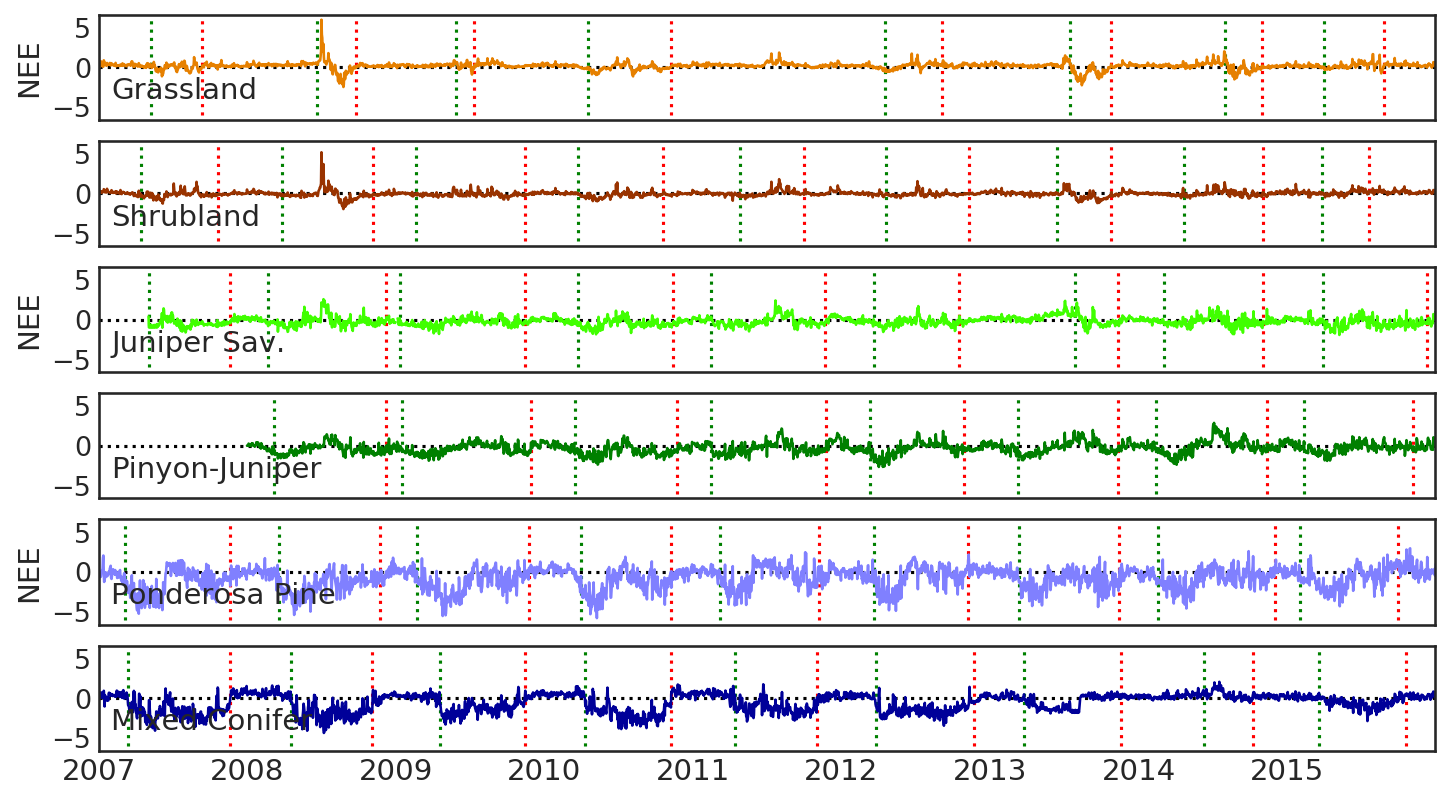

In [6]:
fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'FC_F_g_int', -4, fig, 'NEE')

# Add lines for growing season
for i, site in enumerate(sites):
    ax[i].vlines( list(gs[site].start_seas), [-6], [6], linestyle=':', color='Green' )
    ax[i].vlines( list(gs[site].end_seas), [-6], [6], linestyle=':', color='Red' )


## Get anomaly/climatology data

In [7]:
# Calculate VPD and other anomalies (and normalized versions)
# Dictionaries with series for each site
vpd_anom = {x: tr.var_anomaly(daily[x].VPD_F_max) for x in sites}
vpd_anom_n = {x: tr.var_anomaly(daily[x].VPD_F_max, norm=True) for x in sites}
TA_anom = {x: tr.var_anomaly(daily[x].TA_F_max) for x in sites}
TA_anom_n = {x: tr.var_anomaly(daily[x].TA_F_max, norm=True) for x in sites}
#ef_anom = {x: tr.var_anomaly(daily[x].evap_frac_avg) for x in sites}
#ef_anom_n = {x: tr.var_anomaly(daily[x].evap_frac_avg, norm=True) for x in sites}

## Plot VPD anomaly and normalized anomaly

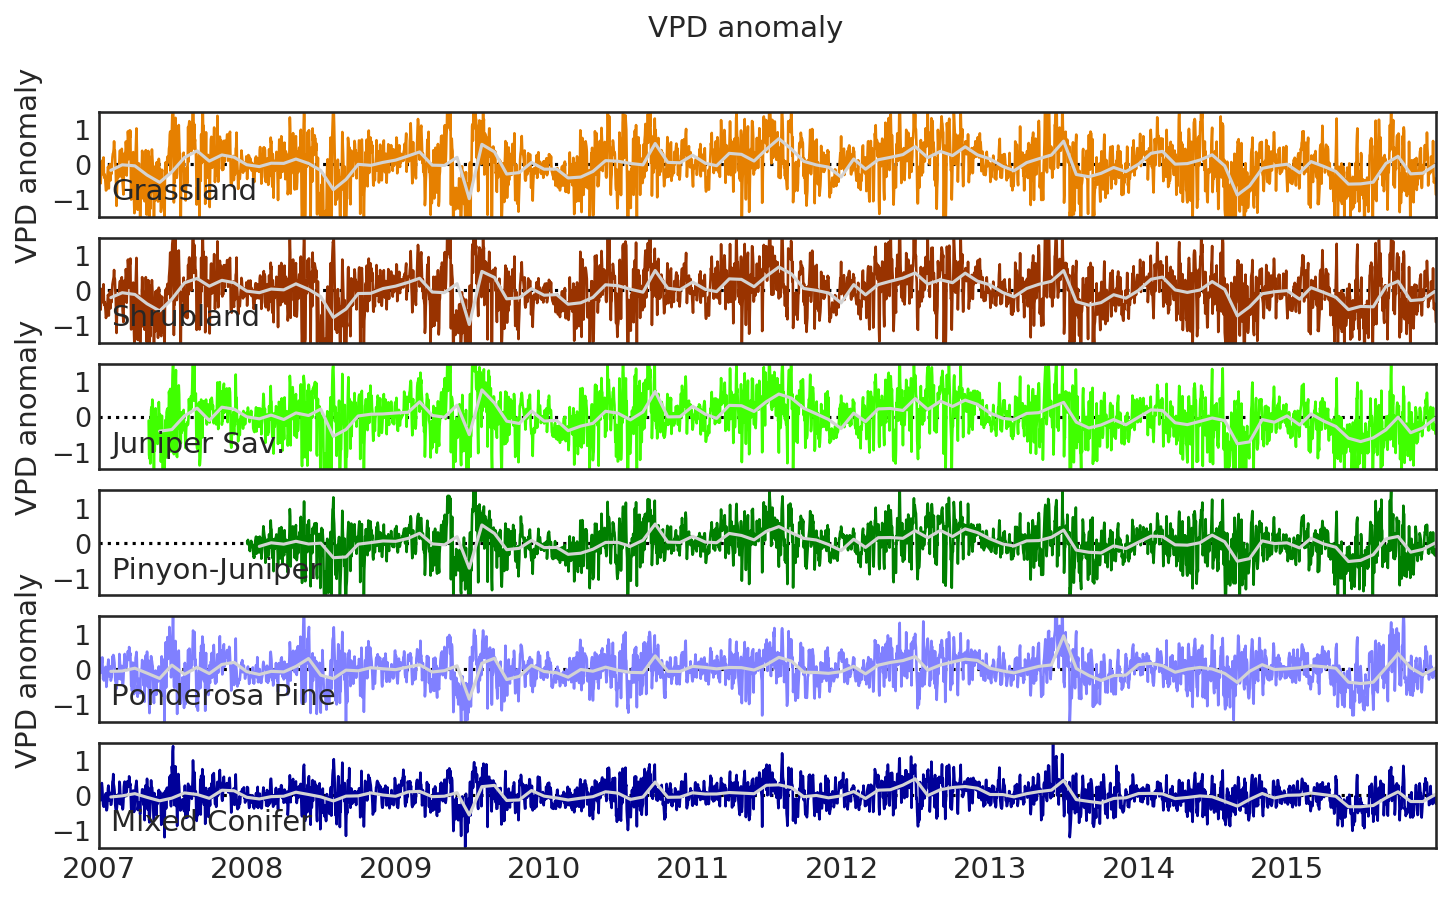

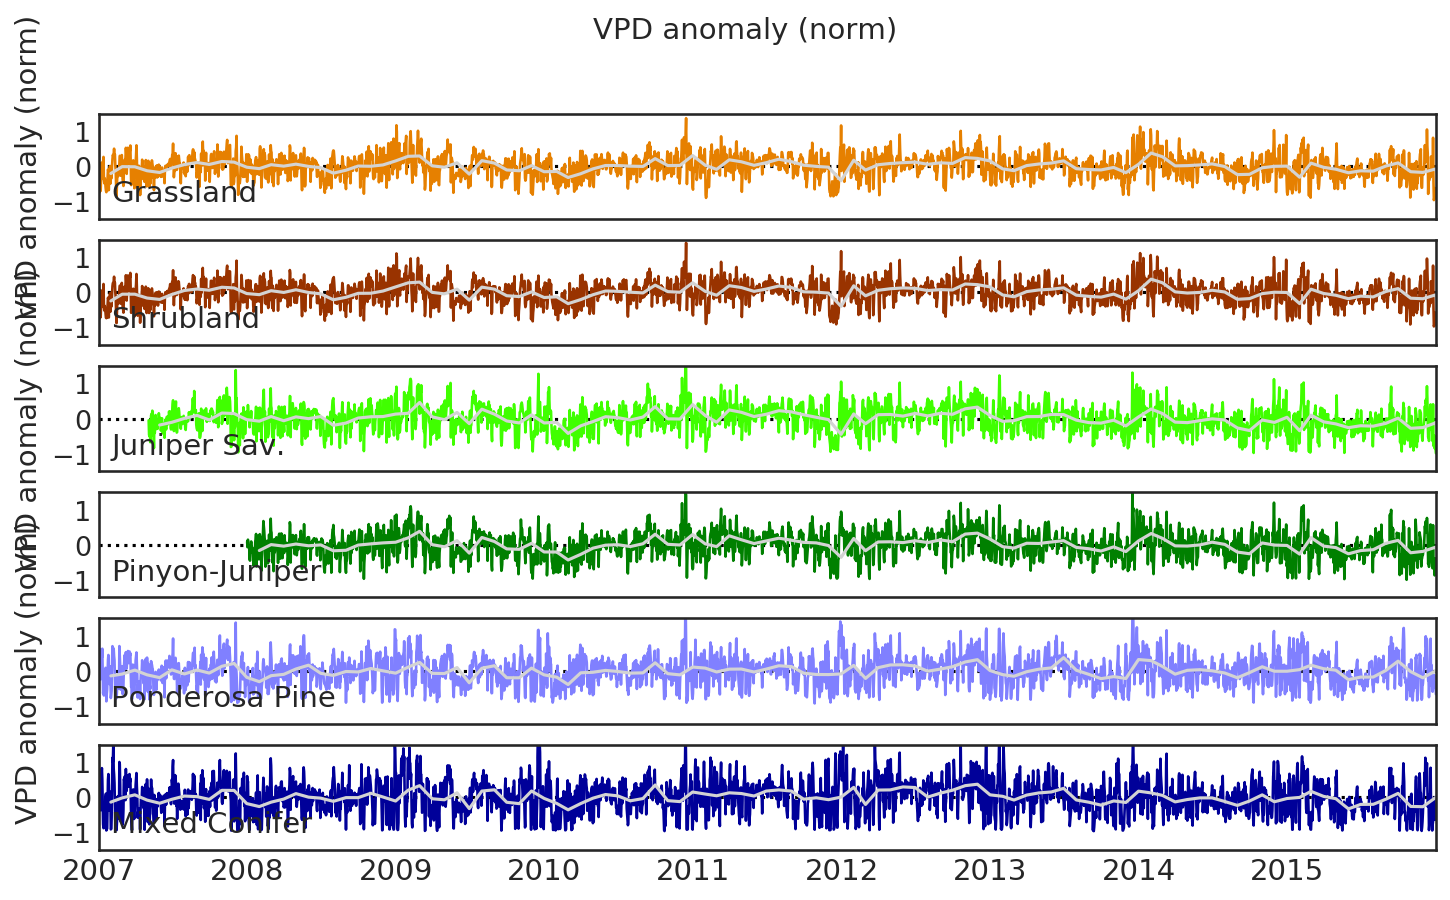

In [8]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

varlist = ['VPD_F', 'VPD_F']
ylabs = ['VPD anomaly', 'VPD anomaly (norm)']
ylims = [[-1.5, 1.5],[-1.5, 1.5]]

for i, anom in enumerate([vpd_anom, vpd_anom_n]):
    # Resample anomaly to monthly mean
    anom_m = { i : anom[i].resample('1M').mean() for i in anom.keys() }
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    ax = nmegplt.plot_tseries(anom, varlist[i], -1, fig, ylabs[i], ylims=ylims[i] )
    for j, site in enumerate(sites):
        ax[j].plot(anom_m[site].index, anom_m[site].values, color='lightgray')
    plt.suptitle(ylabs[i], size=14)

## Plot anomaly and detected conditions

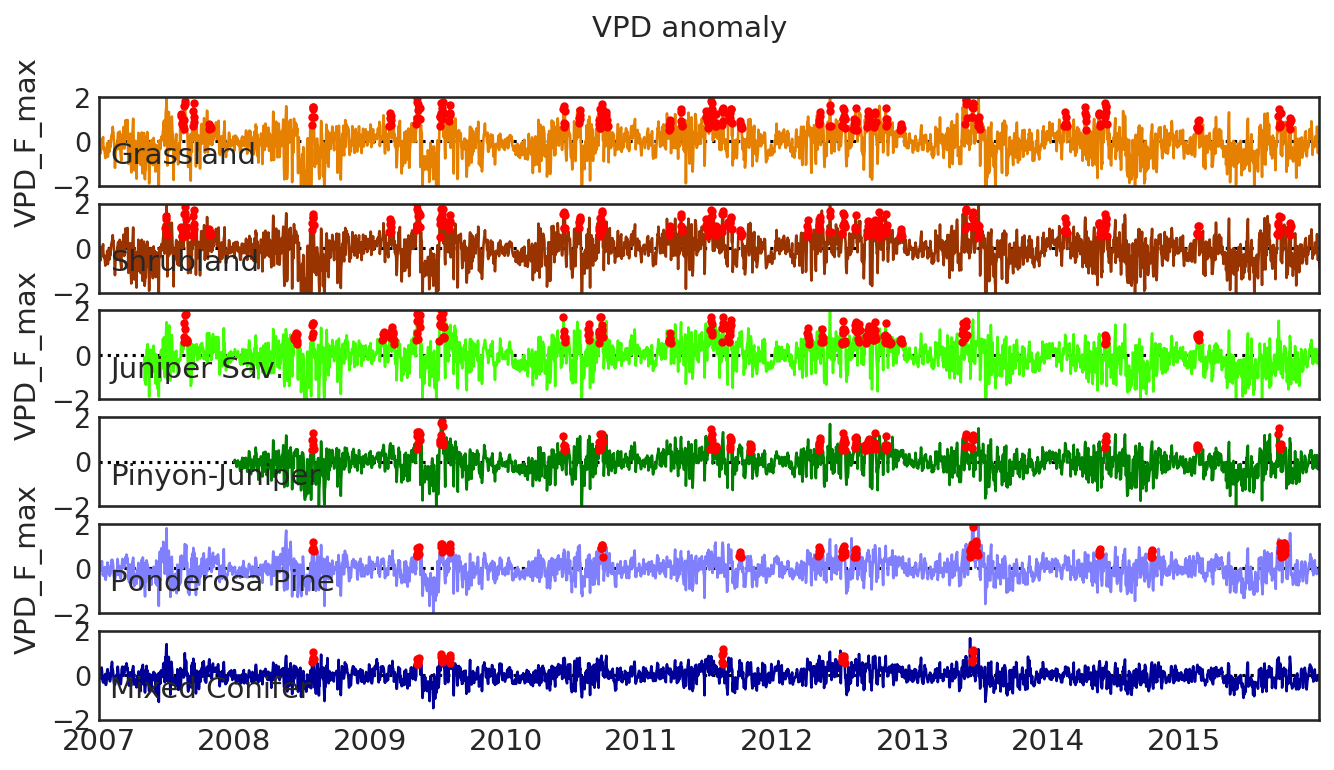

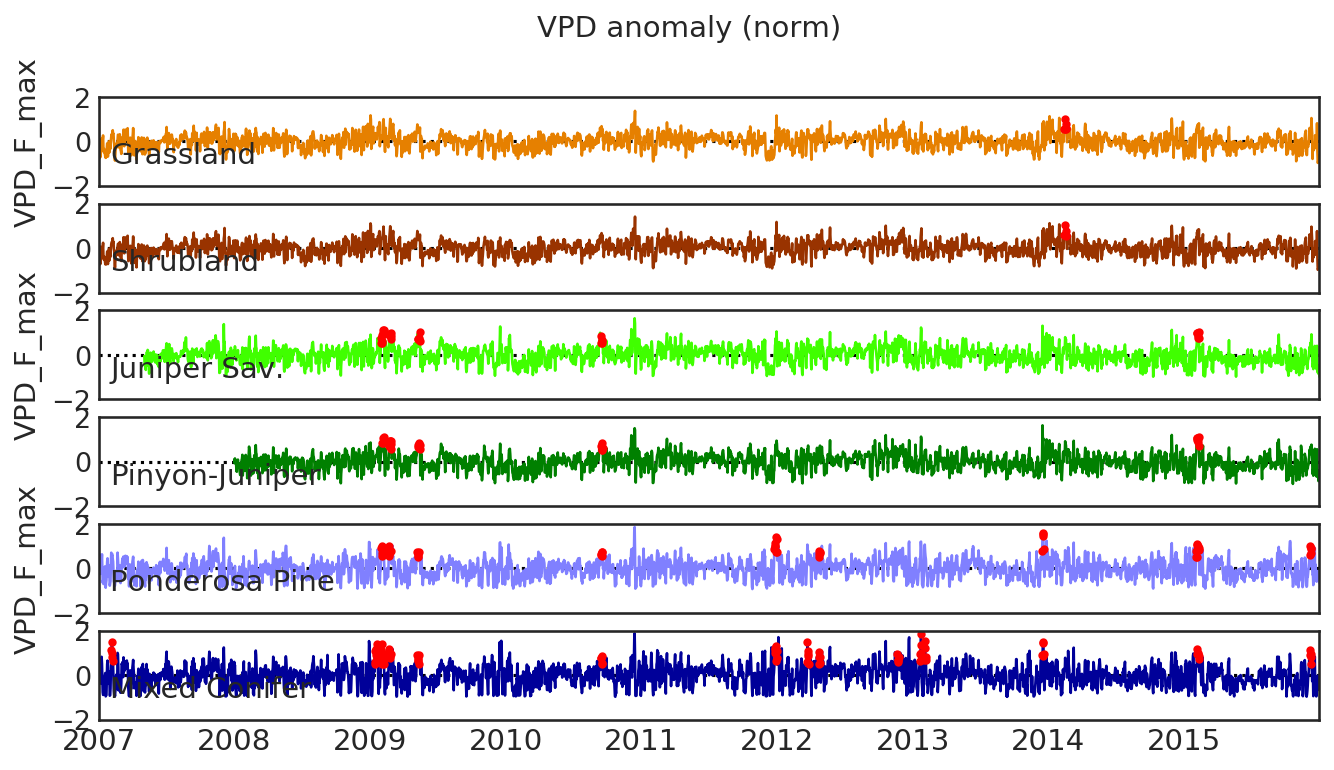

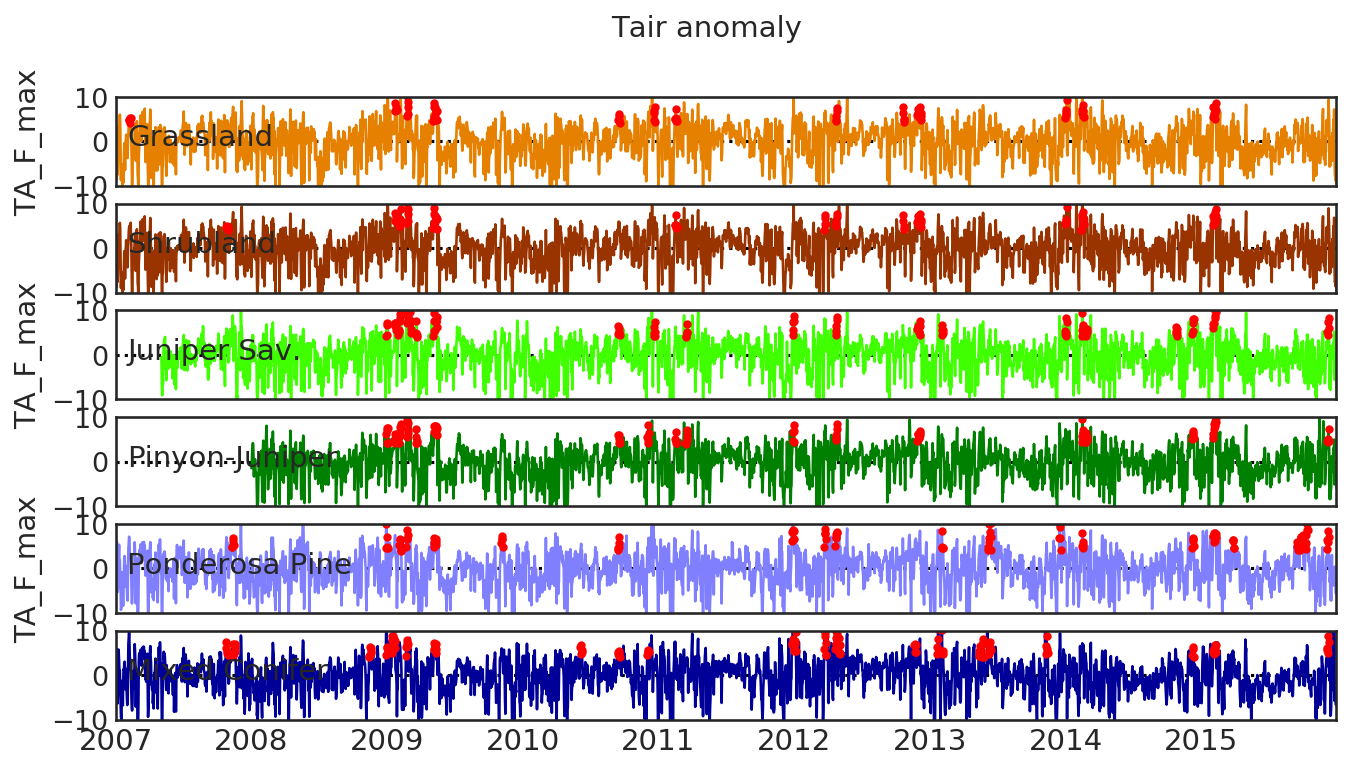

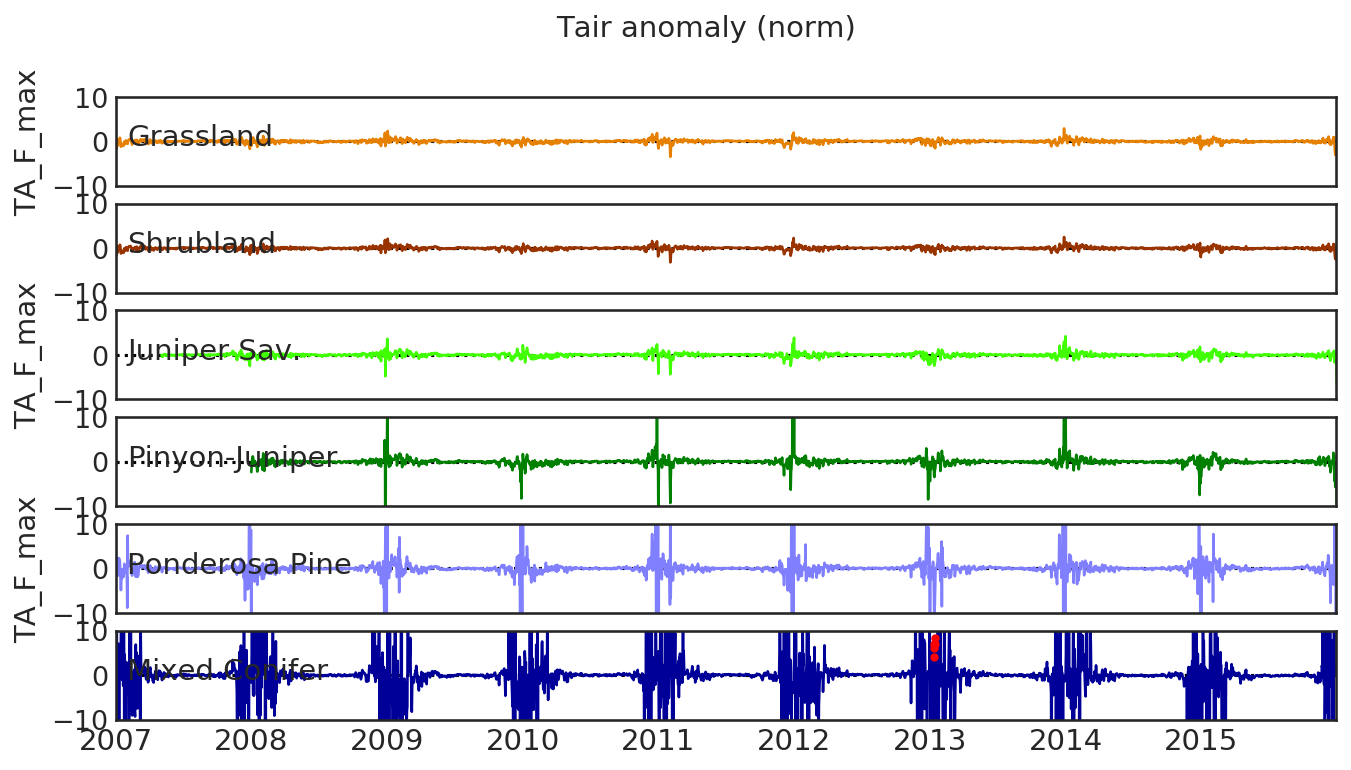

In [9]:
varlist = ['VPD_F_max', 'VPD_F_max', 'TA_F_max', 'TA_F_max']
ylabs = ['VPD anomaly', 'VPD anomaly (norm)', 'Tair anomaly', 'Tair anomaly (norm)']
ylims = [[-2, 2],[-2, 2],[-10, 10],[-10, 10]]
# VPD anomaly (including normalized)
vpd_anom_cond = {x: pd.Series(condition_duration_match( vpd_anom[x] > 0.5, 5 ), 
                         index=vpd_anom[x].index ) for x in vpd_anom.keys()};
vpd_anom_n_cond = {x: pd.Series(condition_duration_match( vpd_anom_n[x] > 0.5, 5 ), 
                         index=vpd_anom_n[x].index ) for x in vpd_anom_n.keys()};
pd.DataFrame(vpd_anom_cond).to_csv('../processed_data/anom_nb_files/VPD_anom_dates.csv')
pd.DataFrame(vpd_anom_n_cond).to_csv('../processed_data/anom_nb_files/VPD_anom_norm_dates.csv')

# Temperature anomaly (including normalized)
TA_anom_cond = {x: pd.Series(condition_duration_match( TA_anom[x] > 4, 5 ), 
                         index=TA_anom[x].index ) for x in TA_anom.keys()};
TA_anom_n_cond = {x: pd.Series(condition_duration_match( TA_anom_n[x] > 4, 5 ), 
                         index=TA_anom_n[x].index ) for x in TA_anom_n.keys()};
pd.DataFrame(TA_anom_cond).to_csv('../processed_data/anom_nb_files/TA_anom_dates.csv')
pd.DataFrame(TA_anom_n_cond).to_csv('../processed_data/anom_nb_files/TA_anom_norm_dates.csv')

# Put together anomalies and plot
anom_cond = [vpd_anom_cond, vpd_anom_n_cond, TA_anom_cond, TA_anom_n_cond]
for i, anom in enumerate([vpd_anom, vpd_anom_n, TA_anom, TA_anom_n]):
    cond = anom_cond[i]
    # Plot timeseries of VPD anomaly and highlight days that meet the conditions above
    fig = plt.figure(figsize=( 10.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
    ax = nmegplt.plot_tseries( anom, varlist[i], -1, fig, varlist[i], ylims=ylims[i])
    for j, site in enumerate(sites):
        series = anom[site].loc[cond[site]]
        ax[j].plot( series.index, series.values, linestyle='None', marker='.', color='Red' )
        
    if i==0:
        fig.savefig('../figures/labmeeting/VPD_anomaly.svg', dpi=150)
    plt.suptitle(ylabs[i], size=14)

## SPEI categories

The following plots rely on SPEI data files generated in R by the "SPEI" package. To re-make the files run the ./SPEI_NMEG notebook.

In [12]:
# Get monthly SPEI and upsample to daily values (by backfilling)
spei_dict = dict
spei_path = '/home/greg/GitHub/NMEG_utils/processed_data/spei/'
spei = {x: pd.read_csv(spei_path + 'SPEI_monthly_US-{0}.csv'.format(x),
                        index_col=0, parse_dates=True) for x in sites}
# Backfill monthly data to make daily values
spei_d = {x: spei[x].resample('1D').bfill() for x in sites}